In [45]:
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Load Iris dataset

In [3]:
iris = load_iris()
X = iris.data
y = iris.target
target_names = iris.target_names

In [5]:
print(f"Data shape: {X.shape}, Labels: {np.unique(y)}")

Data shape: (150, 4), Labels: [0 1 2]


# Perceptron coding

In [9]:
class Perceptron:
    def __init__(self, learning_rate=0.1, n_epochs=10, verbose=False):
        self.lr = learning_rate
        self.n_epochs = n_epochs
        self.verbose = verbose
        self.weights = []
        self.bias = 0

    def fit(self, X, y):
        n_features = len(X[0])
        self.weights = [0] * n_features
        self.bias = 0

        for epoch in range(self.n_epochs):
            for xi, yi in zip(X, y):
                activation = sum(w * x for w, x in zip(self.weights, xi)) + self.bias
                prediction = 1 if activation >= 0 else -1
                if prediction != yi:
                    self.weights = [w + self.lr * yi * x for w, x in zip(self.weights, xi)]
                    self.bias += self.lr * yi
            if self.verbose:
                print(f"Epoch {epoch+1}: Weights = {self.weights}, Bias = {self.bias}")

    def predict(self, x):
        activation = sum(w * xi for w, xi in zip(self.weights, x)) + self.bias
        return 1 if activation >= 0 else -1

    def predict_raw(self, x):
        return sum(w * xi for w, xi in zip(self.weights, x)) + self.bias


In [10]:
class MultiClassPerceptron:
    def __init__(self, learning_rate=0.1, n_epochs=20, verbose=False):
        self.lr = learning_rate
        self.n_epochs = n_epochs
        self.verbose = verbose
        self.models = dict()  # one model per class

    def fit(self, X, y):
        self.classes = sorted(set(y))
        for cls in self.classes:
            binary_y = [1 if yi == cls else -1 for yi in y]
            model = Perceptron(learning_rate=self.lr, n_epochs=self.n_epochs, verbose=self.verbose)
            model.fit(X, binary_y)
            self.models[cls] = model
            if self.verbose:
                print(f"Finished training model for class {cls}")

    def predict(self, x):
        # Run each classifier and return the one with max activation
        scores = {cls: self.models[cls].predict_raw(x) for cls in self.classes}
        return max(scores, key=scores.get)

In [47]:
mcp = MultiClassPerceptron(learning_rate=0.01, n_epochs=1200)
mcp.fit(X.tolist(), y.tolist())

# Predict by perceptron

In [48]:
y_pred = [mcp.predict(xi) for xi in X]

# Plotting decision boundary

C:\Users\Debasmita\AppData\Local\Temp\ipykernel_15396\1275117829.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Accent', len(np.unique(y)))


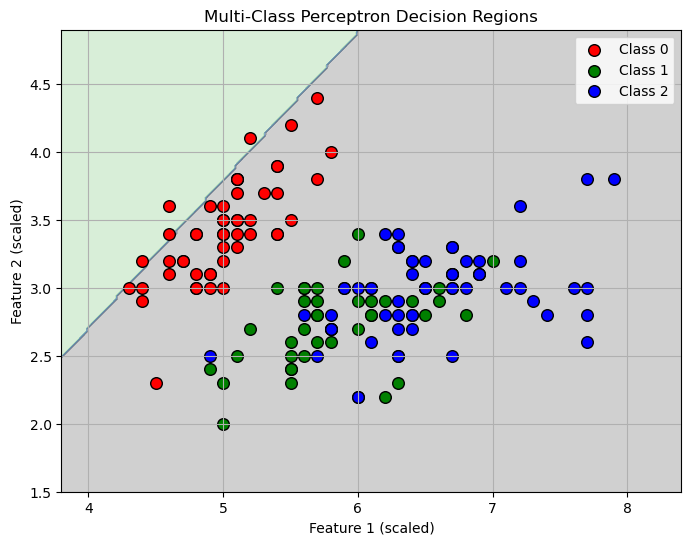

In [49]:
# Convert to numpy if needed
X = np.array(X)
y = np.array(y)

# Create meshgrid
h = 0.02  # grid step size
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Predict for each point in the grid
grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = np.array([mcp.predict(point) for point in grid_points])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(8, 6))
cmap = plt.cm.get_cmap('Accent', len(np.unique(y)))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
# Overlay training points
colors = ['red', 'green', 'blue']
for cls in np.unique(y):
    plt.scatter(X[y == cls, 0], X[y == cls, 1],
                color=colors[cls],
                edgecolors='k',
                label=f"Class {cls}",
                s=70)

plt.xlabel("Feature 1 (scaled)")
plt.ylabel("Feature 2 (scaled)")
plt.title("Multi-Class Perceptron Decision Regions")
plt.legend()
plt.grid(True)
plt.show()


In [51]:
# Ground truth and predictions
y_true = np.array(y)
y_pred = np.array([mcp.predict(xi) for xi in X])
classes = sorted(set(y_true))

# Initialize counters
conf_matrix = np.zeros((len(classes), len(classes)), dtype=int)

for true_label, pred_label in zip(y_true, y_pred):
    conf_matrix[true_label][pred_label] += 1

# Display confusion matrix
print("\n Confusion Matrix:")
print("         Pred →")
print("Actual ↓  ", end="")
for c in classes:
    print(f" {c:5}", end="")
print()
for i, row in enumerate(conf_matrix):
    print(f"Class {i}  ", end="")
    for val in row:
        print(f" {val:5}", end="")
    print()

# Compute metrics
print("\n Classification Report (Per Class):")
for i in classes:
    TP = conf_matrix[i, i]
    FP = conf_matrix[:, i].sum() - TP
    FN = conf_matrix[i, :].sum() - TP
    TN = conf_matrix.sum() - (TP + FP + FN)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall    = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Class {i}: Precision = {precision:.4f}, Recall = {recall:.4f}, F1 = {f1:.4f}")

# Overall accuracy
accuracy = np.mean(y_true == y_pred)
print(f"\n Overall Accuracy: {accuracy * 100:.2f}%")



 Confusion Matrix:
         Pred →
Actual ↓       0     1     2
Class 0      29    21     0
Class 1      40     4     6
Class 2       0     0    50

 Classification Report (Per Class):
Class 0: Precision = 0.4203, Recall = 0.5800, F1 = 0.4874
Class 1: Precision = 0.1600, Recall = 0.0800, F1 = 0.1067
Class 2: Precision = 0.8929, Recall = 1.0000, F1 = 0.9434

 Overall Accuracy: 55.33%


# Why perceptron fails here?
In multi-class tasks like Iris (especially distinguishing class 1 & 2), the classes often overlap in 2D — so a simple linear decision boundary isn’t enough.

Class 0 (Setosa) is linearly separable — perceptron gets it well

Classes 1 (Versicolor) and 2 (Virginica) overlap significantly — need a more powerful model